In [37]:
# Imports
import os
from datasets import Audio, DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback, set_seed
import torch
from torchvision import transforms
import torchaudio 
import torchaudio.transforms as T
import numpy as np
from datasets import Dataset
import random
from PIL import Image, ImageOps
from evaluate import load
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import shutil, os
import librosa

In [38]:
# Parameters
# Loads model and processor, sets training args, sets seed, 
# loads metric, and gets training size

model_name = "google/vit-base-patch16-224-in21k"
if os.path.exists("./vit-base-manuai-peft"):
    model_name = "./vit-base-manuai-peft"
processor = ViTImageProcessor.from_pretrained(model_name)  # Use the processor from the pre-trained model
sample_rate = 22050
epochs = 30
training_args = {
    "output_dir": "./vit-base-manuai-peft",  # save PEFT checkpoints here (separate from merged model)
    "remove_unused_columns": False,
    "learning_rate": 1e-4,  # Learning rate for fine-tuning
    "lr_scheduler_type": "cosine",  # Learning rate scheduler type
    "warmup_ratio": 0.1,  # Warmup ratio for learning rate scheduler
    "per_device_train_batch_size": 8,  # Batch size per device during training 
    "fp16": False,  # Disable mixed precision training
    "bf16": False,  # Disable bfloat16 training
    #"no_cuda": True,  # Disable CUDA to avoid GPU memory issues
    "logging_steps": 100, # Log every 100 steps
    "num_train_epochs": epochs,
    "load_best_model_at_end": True,
    "eval_strategy": "epoch",  # Evaluate at the end of each epoch
    "save_strategy": "epoch",  # Save model at the end of each epoch
    "save_total_limit": 1,  # Limit the number of saved checkpoints
    "label_names": ["label"],
    "weight_decay": 0.001,  # Weight decay for regularization
    "report_to": "tensorboard",
    "load_best_model_at_end": True,
}
n_proc = 1  # Number of processes for parallel processing
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
set_seed(seed)
metric = load("accuracy")
training_size = int(input("Enter the amount of spectrograms per class to train on (0 for all, default 100): ") or 100)

In [ ]:
"""
Load the dataset from the specified path and convert audio data into Mel Spectrograms.
Directory structure:
segments/
├── {english_name}
│   ├── {scientific_name}_{scientific_subspecie}
│   │   ├── {english_name}_{scientific_name}_{scientific_subspecie}_{song}_segment_{num}.wav
"""
# Data augmentation

def augment_audio(sample, force_augment=False):
    waveform, sample_rate = torchaudio.load(sample["audio"]["path"])
    if force_augment or random.random() < 0.7:
        # Apply pitch shifting  
        if random.random() < 0.8:
            n_steps = random.uniform(-3, 3)
            waveform = T.PitchShift(sample_rate, n_steps=n_steps)(waveform)

        # Apply time stretching
        if random.random() < 0.8:
            stretch_factor = random.uniform(0.8, 1.2)
            # Convert to spectrogram
            n_fft = 2048
            window = torch.hann_window(n_fft)
            hop_length = 512
            spec = torch.stft(
                waveform, n_fft=n_fft, hop_length=hop_length, return_complex=True
            )
            # Apply TimeStretch
            time_stretch = T.TimeStretch(hop_length=hop_length, n_freq=spec.size(1))
            spec_stretched = time_stretch(spec, stretch_factor)
            # Convert back to waveform
            waveform = torch.istft(spec_stretched, n_fft=n_fft, hop_length=hop_length)

        # Add noise
        if random.random() < 0.5:
            noise = torch.randn_like(waveform) * 0.01
            waveform = waveform + noise

        # Apply frequency masking
        if random.random() < 0.5:
            waveform = T.FrequencyMasking(freq_mask_param=20)(waveform)

    sample["audio"] = {
        "array": waveform.detach().numpy(),
        "sampling_rate": sample_rate,
        "path": sample["audio"]["path"]
    }
    return sample

segments_path = "./segments"
merged_output_dir = "./vit-base-manuai"

labels = set()

# Collect file paths by class
label_to_files = {}
for root, dirs, files in os.walk(segments_path):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            parts = os.path.splitext(file)[0].split('_')
            if len(parts) >= 2:
                english_name = parts[1]  # Extract label from filename
                labels.add(english_name)
                if english_name not in label_to_files:
                    label_to_files[english_name] = []
                label_to_files[english_name].append(path)

labels = sorted(list(labels))  # deterministic ordering
print("Final label order:", labels)

# Create dataset with up to training_size files per class
# For multi-label, you must define how to assign multiple labels per sample. Here, we assume each sample can belong to multiple classes based on filename or external mapping.
# For demo, we keep single-label per sample, but encode as multi-hot vector.
label_to_id = {lbl: i for i, lbl in enumerate(labels)}

data = []
for label, files in label_to_files.items():
    random.shuffle(files)
    selected_files = files[:training_size]
    if len(selected_files) < training_size:
        augmented_samples = []
        while len(selected_files) + len(augmented_samples) < training_size and len(selected_files) > 0:
            file = random.choice(selected_files)
            sample = {"audio": {"path": file}, "label": label}
            augmented_samples.append(augment_audio(sample, force_augment=True))
        selected_files.extend([s["audio"]["path"] for s in augmented_samples])
    for file in selected_files[:training_size]:
        # Multi-hot encoding: one-hot for single-label, extend for multi-label if needed
        multi_hot = [0] * len(labels)
        multi_hot[label_to_id[label]] = 1
        data.append({"audio": {"path": file}, "label": multi_hot})

# Create dataset
dataset = Dataset.from_list(data)

dataset = dataset.shuffle()

# Cast audio column to use soundfile backend
dataset = dataset.cast_column("audio", Audio(decode=False))

if not dataset:
    print("🚨 Dataset could not be loaded. Check the dataset path and structure.")
if "audio" not in dataset.column_names:
    print("🚨 Dataset does not contain 'audio' column. Check the dataset structure.")

print(f"✅ Dataset loaded with {len(dataset)} samples.")
dataset['audio']

Final label order: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


✅ Dataset loaded with 10000 samples.


Column([{'bytes': None, 'path': './segments/kaka/nestor_meridionalis/962687_kaka_nestor_meridionalis_call_song_segment_36.wav'}, {'bytes': None, 'path': './segments/kaka/nestor_meridionalis/293133_kaka_nestor_meridionalis_call_song_segment_16.wav'}, {'bytes': None, 'path': './segments/fantail/rhipidura_fuliginosa/403123_fantail_rhipidura_fuliginosa_call_song_segment_19.wav'}, {'bytes': None, 'path': './segments/kaka/nestor_meridionalis/925379_kaka_nestor_meridionalis_call_flight_call_segment_12.wav'}, {'bytes': None, 'path': './segments/tui/prosthemadera_novaeseelandiae/956546_tui_prosthemadera_novaeseelandiae_call_segment_66.wav'}])

✅ Unique labels found: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']
Sample dataset entry: {'audio': {'bytes': None, 'path': './segments/kaka/nestor_meridionalis/962687_kaka_nestor_meridionalis_call_song_segment_36.wav'}, 'label': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]}


Converting audio to Mel Spectrograms:   0%|          | 0/10000 [00:00<?, ? examples/s]/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
Converting audio to Mel Spectrograms:   0%|          | 14/10000 [00:00<01:19, 126.36 examples/s]/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
Converting audio to Mel Spectrograms: 100%|██████████| 10000/10000 [02:11<00:00, 75.99 examples/s]



✅ Converted Mel Spectrograms for 10000 samples.


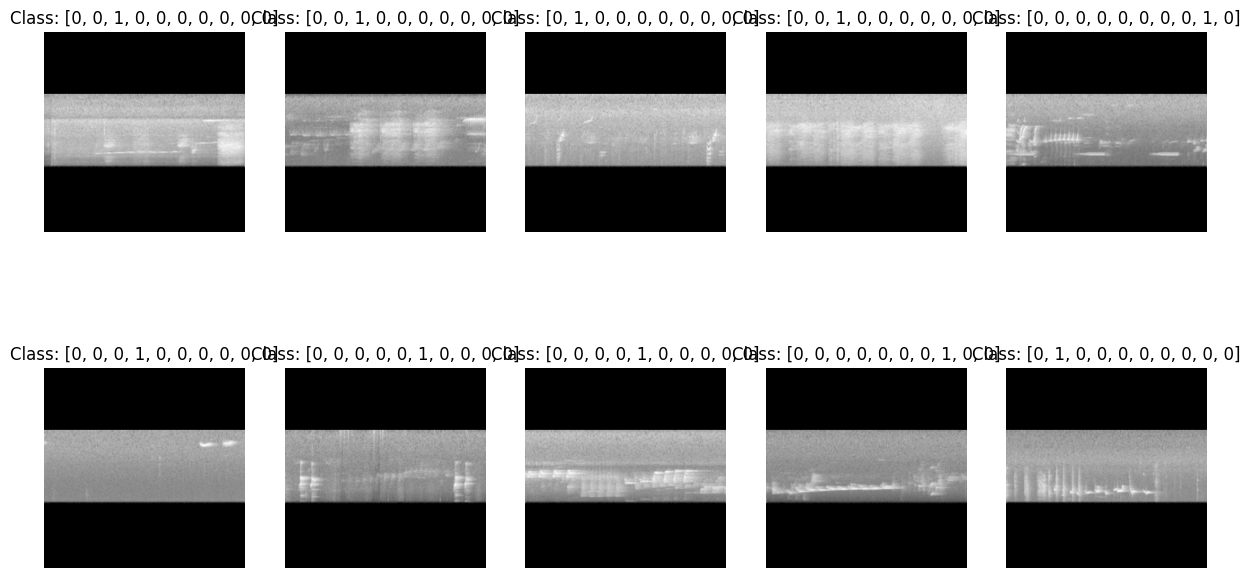

✅ Dataset transformed for model input.


In [ ]:
def convert_to_mel_spectrogram(sample):
    """
    Convert audio waveform to Mel Spectrogram.
    """
    audio_path = sample["audio"]["path"]
    y, sr = librosa.load(audio_path, sr=sample_rate, mono=True)  # resample + mono here
    waveform = torch.from_numpy(y).unsqueeze(0)            # [1, T]
    mode = "basic_rgb"
    target_size = (224, 224)

    # Mel
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=256,
        win_length=768,
        n_mels=128,
        f_min=200,
        f_max=12000,
    )
    mel_spec = mel_spectrogram_transform(waveform)  # [1, n_mels, time]

    if mode == "3channel":
        # Channel 1: log-mel dB
        mel_spec_db = T.AmplitudeToDB()(mel_spec).squeeze(0).numpy()  # [n_mels, time]

        # Channel 2: PCEN
        mel_np = mel_spec.squeeze(0).numpy()  # [n_mels, time]
        mel_spec_pcen = librosa.pcen(mel_np * (2**31), sr=sample_rate)  # scale to avoid tiny values

        # Channel 3: delta
        delta_spec = librosa.feature.delta(mel_spec_db)

        def normalize_img(x):
            x = x - x.min()
            denom = x.max() if x.max() > 0 else 1.0
            return ((x / denom) * 255).astype(np.uint8)

        ch1 = normalize_img(mel_spec_db)
        ch2 = normalize_img(mel_spec_pcen)
        ch3 = normalize_img(delta_spec)

        rgb_image = np.stack([ch1, ch2, ch3], axis=-1)  # [H, W, 3]
        img = Image.fromarray(rgb_image)
        img = ImageOps.pad(img, target_size, color=(0,0,0))  # pad to 224x224 without stretching
        sample["image"] = img
        return sample
    elif mode == "basic_rgb":
        mel_spec = mel_spectrogram_transform(waveform)
        amplitude_to_db = T.AmplitudeToDB()
        mel_spec_db = amplitude_to_db(mel_spec)
        
        # Convert to numpy and normalise
        mel_spec_np = mel_spec_db.squeeze().numpy()
        normalized = ((mel_spec_np - mel_spec_np.min()) / 
                    (mel_spec_np.max() - mel_spec_np.min()) * 255).astype(np.uint8)
        
        # Convert to RGB image
        rgb_image = np.stack([normalized] * 3, axis=-1)
        img = Image.fromarray(rgb_image)
        img = ImageOps.pad(img, target_size, color=(0,0,0))  # pad to 224x224 without stretching
        sample["image"] = img
        return sample

def extract_label(sample):
    """
    Extract labels from the dataset.
    The file names are formatted as '{bird_id}_{english_name}_{scientific_name}_{scientific_subspecie}_{song}_segment_{num}.wav'.
    """
    # Extract the label from the file name
    audio_path = sample["audio"]["path"]
    # Get just the filename without the path
    filename = os.path.basename(audio_path)
    # Remove the .wav extension
    filename_without_ext = os.path.splitext(filename)[0]
    # Split by underscore and get the english name (second element)
    parts = filename_without_ext.split('_')
    if len(parts) >= 2:
        english_name = parts[1]  # Second element is the English name
    else:
        # Fallback if filename doesn't match expected format
        english_name = "unknown"
    
    sample["class"] = english_name
    #print(f"Extracted label: {sample['label']} from filename: {filename}")
    return sample

def transform(sample):
    inputs = processor([x for x in sample["image"]], return_tensors="pt", do_normalize=True)

    # SpecAugment-style augmentations
    spec_augment = torch.nn.Sequential(
        torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
        torchaudio.transforms.TimeMasking(time_mask_param=30)
    )

    # Apply augmentations with some probability
    if torch.rand(1).item() < 0.5:
        inputs["pixel_values"] = spec_augment(inputs["pixel_values"])

    augment = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # keep consistent scaling
    ])
    inputs["pixel_values"] = torch.stack([augment(img) for img in inputs["pixel_values"]])
    # Pass multi-hot label vector as 'labels'
    inputs["labels"] = sample["label"]
    return inputs

print(f"✅ Unique labels found: {labels}")
# print contents of sample
print(f"Sample dataset entry: {dataset[0]}")

# Convert audio data into Mel Spectrograms
dataset = dataset.map(
    convert_to_mel_spectrogram, 
    remove_columns=["audio"],
    desc="Converting audio to Mel Spectrograms",
    num_proc=n_proc,  # Use multiple processes for faster processing
)

# Check if Mel Spectrograms are created correctly
if "image" not in dataset.column_names:
    print("🚨 Mel Spectrograms were not created correctly. Check the conversion logic.")
print(f"✅ Converted Mel Spectrograms for {len(dataset)} samples.")

# Show 10 sample images and save to folder "/spectrograms"
if len(dataset) > 0:
    plt.figure(figsize=(15, 8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(dataset[i]["image"], cmap="gray")
        plt.title(f"Class: {dataset[i]['label']}")
        plt.axis("off")
        img = dataset[i]["image"]
        # Save the image to spectrograms folder
        if not os.path.exists("spectrograms"):
            os.makedirs("spectrograms")
        img.save(f"spectrograms/sample_{i}.png")
    plt.show()
else:
    print("🚨 Dataset is empty after transformation. Check the dataset processing steps.")

# Transform the dataset for the model
dataset = dataset.with_transform(transform)
print("✅ Dataset transformed for model input.")

In [41]:
# Training the model

def collate_fn(batch):
    """
    Custom collate function for multi-label: stack pixel_values and labels as float tensors.
    """
    return {
        "pixel_values": torch.stack([item["pixel_values"] for item in batch]),
        "labels": torch.tensor([item["labels"] for item in batch], dtype=torch.float)
    }

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, top_k_accuracy_score

def compute_metrics(p):
    # Multi-label: apply sigmoid, threshold at 0.3
    preds = torch.sigmoid(torch.tensor(p.predictions)).numpy()
    y_pred = (preds > 0.3).astype(int)
    y_true = p.label_ids.astype(int)
    per_label_acc = (y_pred == y_true).mean(axis=0).mean()
    return {
        "per_label_accuracy": per_label_acc,
        #"top_3_accuracy": top_k_accuracy_score(y_true, y_pred, k=3),
        "f1": f1_score(y_true, y_pred, average="samples"),
        "precision": precision_score(y_true, y_pred, average="samples"),
        "recall": recall_score(y_true, y_pred, average="samples")
    }

# Remove 'label_names' from training_args if present
if "label_names" in training_args:
    del training_args["label_names"]

train, test = dataset.train_test_split(test_size=0.2, seed=42).values()

dataset_dict = DatasetDict({
    "train": train,
    "test": test,
})

processor = ViTImageProcessor.from_pretrained(model_name)

callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    problem_type="multi_label_classification"
)

lora_config = LoraConfig(
        r=16, # LoRA rank
        lora_alpha=16, 
        target_modules=["query", "key", "value"],
        lora_dropout=0.05,
        bias="none",
        modules_to_save=["classifier"],
    )

model = get_peft_model(model, lora_config)

trainer = Trainer(
    model=model,
    args=TrainingArguments(**training_args),
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['test'],
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    processing_class=processor,  
    callbacks=callbacks, 
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modif

In [42]:
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)

    print(f"Model Size: {(size / 1e6):.2} MB")

def print_label_and_id():
    print("Labels and their assigned IDs:")
    for i, label in enumerate(labels):
        print(f"{label}: {i}")


def print_trainable_parameters(model, label):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)")

print_trainable_parameters(model, "LoRA")
print_label_and_id()

LoRA trainable parameters: 892,426/86,698,772 (1.03%)
Labels and their assigned IDs:
bellbird: 0
fantail: 1
kaka: 2
morepork: 3
robin: 4
saddleback: 5
silvereye: 6
tomtit: 7
tui: 8
whitehead: 9


In [43]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Per Label Accuracy,F1,Precision,Recall
1,0.261000,0.255185,0.912850,0.260500,0.257333,0.267000
2,0.190600,0.185011,0.927500,0.555500,0.539583,0.588000
3,0.157000,0.157973,0.939050,0.646000,0.632417,0.673500
4,0.134200,0.139117,0.942150,0.696000,0.678167,0.732000
5,0.115700,0.124300,0.952900,0.730500,0.716750,0.758500
6,0.107300,0.110634,0.958050,0.763750,0.754417,0.782500
7,0.099800,0.109699,0.955900,0.763583,0.750167,0.790500
8,0.081700,0.109698,0.955150,0.784250,0.768667,0.816000
9,0.081400,0.108093,0.958400,0.786000,0.774667,0.809000
10,0.076900,0.093341,0.961750,0.813033,0.798042,0.843500


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precisio

***** train metrics *****
  epoch                    =          26.0
  total_flos               = 15168580928GF
  train_loss               =        0.0774
  train_runtime            =    2:26:15.63
  train_samples_per_second =        27.348
  train_steps_per_second   =         3.419


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/utils/other.py:1228: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /google/vit-base-patch16-224-in21k/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x385e41150>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 501a698a-9245-4e25-a6b1-9b817a58f7c8)') - silently ignoring the lookup for the file config.json in google/vit-base-patch16-224-in21k.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/utils/save_and_load.py:286: UserWarning: Could not find a config file in google/vit-base-patch16-224-in21k - will assume that the vocabulary was not modified.
  warnings.warn(


In [44]:
print_model_size(training_args["output_dir"])
metrics = trainer.evaluate(eval_dataset=dataset_dict['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Model Size: 3.6 MB


***** eval metrics *****
  epoch                   =       26.0
  eval_f1                 =     0.8669
  eval_loss               =     0.0805
  eval_per_label_accuracy =     0.9739
  eval_precision          =     0.8598
  eval_recall             =     0.8815
  eval_runtime            = 0:00:34.05
  eval_samples_per_second =     58.727
  eval_steps_per_second   =      7.341


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy per class:
bellbird: 0.96
fantail: 0.98
kaka: 0.98
morepork: 0.99
robin: 0.98
saddleback: 0.97
silvereye: 0.99
tomtit: 0.98
tui: 0.95
whitehead: 0.96


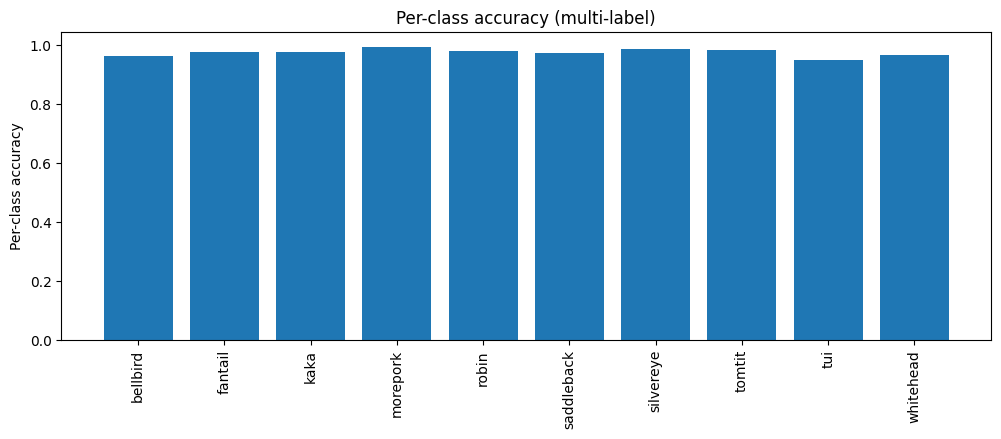

In [45]:
predictions = trainer.predict(dataset_dict['test'])
y_true = predictions.label_ids
y_pred = (torch.sigmoid(torch.tensor(predictions.predictions)).numpy() > 0.3).astype(int)

# Per-class accuracy
per_class_accuracy = (y_true == y_pred).sum(axis=0) / y_true.shape[0]
accuracy_per_class = {label: float(acc) for label, acc in zip(labels, per_class_accuracy)}

print("Accuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"{label}: {acc:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.bar(range(len(labels)), per_class_accuracy)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.ylabel("Per-class accuracy")
plt.title("Per-class accuracy (multi-label)")
plt.show()

In [46]:
# F1 score, precision, recall
from sklearn.metrics import roc_auc_score, hamming_loss, accuracy_score, f1_score, precision_score, recall_score

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
try:
    roc_auc_macro = roc_auc_score(y_true, predictions.predictions, average='macro')
    roc_auc_micro = roc_auc_score(y_true, predictions.predictions, average='micro')
    roc_auc_per_class = roc_auc_score(y_true, predictions.predictions, average=None)
    print(f"ROC-AUC Macro: {roc_auc_macro:.2f}")
    print(f"ROC-AUC Micro: {roc_auc_micro:.2f}")
    for i, label in enumerate(labels):
        print(f"ROC-AUC {label}: {roc_auc_per_class[i]:.2f}")
except Exception as e:
    print("ROC-AUC could not be computed:", e)

# Hamming loss
hamming = hamming_loss(y_true, y_pred)
print(f"Hamming Loss: {hamming:.4f}")

# Subset accuracy (exact match)
subset_acc = accuracy_score(y_true, y_pred)
print(f"Subset Accuracy (exact match): {subset_acc:.2f}")

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

ROC-AUC Macro: 0.98
ROC-AUC Micro: 0.98
ROC-AUC bellbird: 0.98
ROC-AUC fantail: 0.98
ROC-AUC kaka: 0.98
ROC-AUC morepork: 1.00
ROC-AUC robin: 0.99
ROC-AUC saddleback: 0.99
ROC-AUC silvereye: 0.99
ROC-AUC tomtit: 0.99
ROC-AUC tui: 0.95
ROC-AUC whitehead: 0.98
Hamming Loss: 0.0253
Subset Accuracy (exact match): 0.85
F1 Score: 0.87
Precision: 0.87
Recall: 0.88


In [47]:
# import IPython.display as ipd
# misclassified_indices = np.where(y_true != y_pred)[0]
# for idx in misclassified_indices:
#     print(f"Misclassified sample {idx}: true label = {y_true[idx]}, predicted label = {y_pred[idx]}")
#     choice = input("Would you like to listen? (y/n): ")
#     if choice.lower() == "y":
#         sample = dataset_dict['test'][misclassified_indices[0]]
#         ipd.Audio(sample['audio']['path'])

In [48]:
# Always merge LoRA adapter with the correct base model for standalone inference export
from transformers import ViTForImageClassification
from peft import PeftModel
base_model_name = "google/vit-base-patch16-224-in21k"  # or your original base model
peft_model_path = training_args["output_dir"]  # path to LoRA/PEFT checkpoint folder
base_model = ViTForImageClassification.from_pretrained(
    base_model_name,
    num_labels=len(labels),
    id2label={str(i): lbl for i, lbl in enumerate(labels)},
    label2id={lbl: i for i, lbl in enumerate(labels)},
    problem_type="multi_label_classification"
)
peft_model = PeftModel.from_pretrained(base_model, peft_model_path)
merged_model = peft_model.merge_and_unload()

# Ensure label maps and num_labels are embedded in the saved config
merged_model.config.problem_type = "multi_label_classification"
merged_model.config.id2label = {str(i): lbl for i, lbl in enumerate(labels)}
merged_model.config.label2id = {lbl: i for i, lbl in enumerate(labels)}
merged_model.config.num_labels = len(labels)

# Save merged model and processor to a clean folder
if os.path.exists(merged_output_dir):
    shutil.rmtree(merged_output_dir)
os.makedirs(merged_output_dir, exist_ok=True)

merged_model.save_pretrained(merged_output_dir)
processor.save_pretrained(merged_output_dir)

print("Merged model and processor saved to", merged_output_dir)
print("Use `from_pretrained` to load the model and processor for inference.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Merged model and processor saved to ./vit-base-manuai
Use `from_pretrained` to load the model and processor for inference.


In [ ]:
!zip -r vit-base-manuai.zip vit-base-manuai
print("Model saved as vit-base-manuai.zip")
print("Training complete. Model and metrics saved.")

updating: vit-base-manuai/ (stored 0%)
updating: vit-base-manuai/model.safetensors (deflated 7%)
updating: vit-base-manuai/config.json (deflated 54%)
updating: vit-base-manuai/preprocessor_config.json (deflated 47%)
 (deflated 7%)
updating: vit-base-manuai/config.json (deflated 54%)
updating: vit-base-manuai/preprocessor_config.json (deflated 47%)
Model saved as vit-base-manuai.zip
Training complete. Model and metrics saved.
Model saved as vit-base-manuai.zip
Training complete. Model and metrics saved.


In [50]:
import json

# Collect all metrics into a dictionary
metrics_to_save = {
    "train_metrics": train_results.metrics if 'train_results' in locals() else {},
    "eval_metrics": metrics if 'metrics' in locals() else {},
    "f1_score": float(f1) if 'f1' in locals() else None,
    "precision": float(precision) if 'precision' in locals() else None,
    "recall": float(recall) if 'recall' in locals() else None,
    "accuracy_per_class": accuracy_per_class if 'accuracy_per_class' in locals() else {},
    "hamming_loss": float(hamming) if 'hamming' in locals() else None,
    "subset_accuracy": float(subset_acc) if 'subset_acc' in locals() else None,
    "roc-auc": {
        "macro": float(roc_auc_macro) if 'roc_auc_macro' in locals() else None,
        "micro": float(roc_auc_micro) if 'roc_auc_micro' in locals() else None,
        "per_class": {label: float(roc_auc) for label, roc_auc in zip(labels, roc_auc_per_class)} if 'roc_auc_per_class' in locals() else {}
    }
}

# Save to a JSON file
with open("all_metrics.json", "w") as f:
    json.dump(metrics_to_save, f, indent=2)

print("All metrics saved to all_metrics.json")

All metrics saved to all_metrics.json
